In [48]:
import math
import spicy
import pandas as pd
import yfinance as yf
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt

from scipy.optimize import linprog


Problem 1
Part 1


Suppose we buy $ x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_{10}, x_{11}, x_{12} $ shares of bond1 to bond12 respectively. And suppose we could carry $z_0$ money from year 0 to year 1, that is instead of buying the bond in year 0, we keep the money and use it in year 1. Similarly, we hvae $z_i$ means we carry $z_i$ money from year i to year i+1, and we define $z_0$ to $z_6$ here. Also, we have forward rate $f_{0,1}, f_{1,2}, f_{2,3}, f_{3,4}, f_{4,5}, f_{5,6}$ represents to the forward rate $f_{i,j}$ from year i to year j. And now, we could have the models below:


$$
10x_1 + 7x_2 + 8x_3 + 6x_4 + 7x_5 + 6x_6 + 5x_7 + 10x_8 + 8x_9 + 6x_{10} + 10 x_{11} + 7x_{12} + z_0 * (1+f_{0,1}) - z_1 \geq 500
$$
$$
10x_1 + 7x_2 + 8x_3 + 6x_4 + 7x_5 + 6x_6 + 5x_7 + 10x_8 + 8x_9 + 6x_{10} + 110 x_{11} + 107x_{12} + z_1 * (1+f_{1,2})  - z_2 \geq 200
$$
$$
10x_1 + 7x_2 + 8x_3 + 6x_4 + 7x_5 + 6x_6 + 5x_7 + 110x_8 + 108x_9 + 106x_{10} + z_2 * (1+f_{2,3})  - z_3 \geq 800
$$
$$
10x_1 + 7x_2 + 8x_3 + 6x_4 + 7x_5 + 106x_6 + 105x_7 + z_3 * (1+f_{3,4})  - z_4 \geq 200
$$
$$
10x_1 + 7x_2 + 8x_3 + 106x_4 + 107x_5 + z_4 * (1+f_{4,5})  - z_5 \geq 800
$$
$$
110x_1 + 107x_2 + 108x_3 + z_5 * (1+f_{5,6}) \geq 1200
$$
$$
x_1 \geq 0, x_2 \geq 0, x_3 \geq 0, x_4 \geq 0, x_5 \geq 0, x_6 \geq 0, x_7 \geq 0, x_8 \geq 0, x_9 \geq 0, x_{10} \geq 0, x_{11} \geq 0, x_{12} \geq 0
$$
$$
z_0 \geq 0, z_1 \geq 0, z_2 \geq 0, z_3 \geq 0, z_4 \geq 0, z_5 \geq 0
$$


And we could easily get $f_{i,j} = (\frac{(1+s_j)^j}{(1+s_i)^i})^{\frac{1}{j - i}} - 1$:

In [49]:
def forwardRate (s, i, j):
    sj = (1+s[j - 1])**j
    si = (1+s[i - 1])**i
    fij = (sj/si)**(1/(j-i)) - 1
    return fij

spotRates = [5.04/100, 5.94/100, 6.36/100, 7.18/100, 7.89/100, 8.39/100]
f01 = spotRates[0] + 1
f12 = forwardRate (spotRates, 1, 2) + 1
f23 = forwardRate (spotRates, 2, 3) + 1
f34 = forwardRate (spotRates, 3, 4) + 1
f45 = forwardRate (spotRates, 4, 5) + 1
f56 = forwardRate (spotRates, 5, 6) + 1

print(f01, f12, f23, f34 , f45, f56)

1.0504 1.0684771134805786 1.0720500188162407 1.0967812688870346 1.1077734562606916 1.109249731433675


And then we use the model above, getting the matrix below:

In [ ]:
bonds = [
    [10, 10, 10, 10, 10, 110],
    [7, 7, 7, 7, 7, 107],
    [8, 8, 8, 8, 8, 108],
    [6, 6, 6, 6, 106, 0],
    [7, 7, 7, 7, 107, 0],
    [6, 6, 6, 106, 0, 0],
    [5, 5, 5, 105, 0, 0],
    [10, 10, 110, 0, 0, 0],
    [8, 8, 108, 0, 0, 0],
    [6, 6, 106, 0, 0, 0],
    [10, 110, 0, 0, 0, 0],
    [7, 107, 0, 0, 0, 0]]
c = [109, 94.8, 99.5, 93.1, 97.2, 96.3, 92.9, 110, 104, 101, 107, 102, 1, 0, 0, 0, 0, 0]  # price for each bond and cash
#     x1,  x2,  x3,   x4,   x5,   x6,   x7,   x8,   x9, x10, x11, x12,z0,z1,z2,z3,z4,z5

# Inequality constraints (A_ub * x <= b_ub)
A_ub = [[10, 7, 8, 6, 7, 6, 5, 10, 8, 6, 10, 7, f01, -1, 0, 0, 0, 0],
        [10, 7, 8, 6, 7, 6, 5 , 10, 8, 6, 110, 107, 0, f12, -1, 0, 0, 0],
        [10, 7, 8, 6, 7, 6, 5,  110, 108, 106,0,0,0, 0, f23, -1, 0, 0],
        [10, 7, 8, 6, 7, 106, 105,0,0,0,0,0,0, 0, 0, f34, -1, 0],
        [10, 7, 8, 106, 107,0,0,0,0,0,0,0, 0, 0,0, 0, f45, -1],
        [110,107,108,0,0,0,0,0,0,0,0,0, 0, 0, 0,0, 0, f56]]
b_ub = [500, 200, 800, 200, 800, 1200]


# reverse the matrix since we need >=
for i in range(0, len(A_ub)):
    for j in range(0, len(A_ub[i])):
        A_ub[i][j] = -A_ub[i][j]

for i in range(0, len(b_ub)):
    b_ub[i] = -b_ub[i]
    
print(A_ub)

# Bounds for xi and zi
x_bounds = [(0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None)]  # x1 >= 0, x2 >= 0

# Solve the linear program
result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=x_bounds, method='highs')

# Display results
if result.success:
    print("Optimal value:", result.fun)
    print("Optimal solution:", result.x)
else:
    print("Optimization failed:", result.message)

[[-10, -7, -8, -6, -7, -6, -5, -10, -8, -6, -10, -7, -1.0504, 1, 0, 0, 0, 0], [-10, -7, -8, -6, -7, -6, -5, -10, -8, -6, -110, -107, 0, -1.0684771134805786, 1, 0, 0, 0], [-10, -7, -8, -6, -7, -6, -5, -110, -108, -106, 0, 0, 0, 0, -1.0720500188162407, 1, 0, 0], [-10, -7, -8, -6, -7, -106, -105, 0, 0, 0, 0, 0, 0, 0, 0, -1.0967812688870346, 1, 0], [-10, -7, -8, -106, -107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.1077734562606916, 1], [-110, -107, -108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.109249731433675]]
Optimal value: 2745.5803945262583
Optimal solution: [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
   23.28247344    0.          254.35573648    0.         2361.07207836
 1731.18736603 1698.733876   1081.81229708]


The result showing that we should buy 23.28 units of bond11, and keep 254.36 cash in hand, the total cost is 2745.58


(b)

We need make sure the number of units of Bond 2 and Bond 3 are restricted to no more than 5% of the total units of bonds
Thus, we have:
$$
\frac{5}{100}(x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9 + x_{10} + x_{11} + x_{12}) \geq x_2
$$
$$
\frac{5}{100}(x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9 + x_{10} + x_{11} + x_{12}) \geq x_3
$$

Move x2, x3 to LHS, easily we get 2 more constraints:
$$
\frac{5}{100}(x_1 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9 + x_{10} + x_{11} + x_{12}) - \frac{95}{100}x_2 \geq 0
$$
$$
\frac{5}{100}(x_1 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9 + x_{10} + x_{11} + x_{12}) - \frac{95}{100}x_3 \geq 0
$$

So adding these 2 into our code, we get the new matrix:

In [51]:
c = [109, 94.8, 99.5, 93.1, 97.2, 96.3, 92.9, 110, 104, 101, 107, 102, 1, 0, 0, 0, 0, 0]  # price for each bond and cash
#     x1,  x2,  x3,   x4,   x5,   x6,   x7,   x8,   x9, x10, x11, x12,z0,z1,z2,z3,z4,z5

# Inequality constraints (A_ub * x <= b_ub)
A_ub = [[10, 7, 8, 6, 7, 6, 5, 10, 8, 6, 10, 7, f01, -1, 0, 0, 0, 0],
        [10, 7, 8, 6, 7, 6, 5 , 10, 8, 6, 110, 107, 0, f12, -1, 0, 0, 0],
        [10, 7, 8, 6, 7, 6, 5,  110, 108, 106,0,0,0, 0, f23, -1, 0, 0],
        [10, 7, 8, 6, 7, 106, 105,0,0,0,0,0,0, 0, 0, f34, -1, 0],
        [10, 7, 8, 106, 107,0,0,0,0,0,0,0, 0, 0,0, 0, f45, -1],
        [110,107,108,0,0,0,0,0,0,0,0,0, 0, 0, 0,0, 0, f56],
        [5/100,-95/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100, 0, 0, 0,0, 0, 0],
        [5/100,5/100,-95/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100, 0, 0, 0,0, 0, 0]]
b_ub = [500, 200, 800, 200, 800, 1200, 0, 0]


# reverse the matrix since we need >=
for i in range(0, len(A_ub)):
    for j in range(0, len(A_ub[i])):
        A_ub[i][j] = -A_ub[i][j]

for i in range(0, len(b_ub)):
    b_ub[i] = -b_ub[i]
    
print(A_ub)

# Bounds for xi and zi
x_bounds = [(0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None)]  # x1 >= 0, x2 >= 0

# Solve the linear program
result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=x_bounds, method='highs')

# Display results
if result.success:
    print("Optimal value:", result.fun)
    print("Optimal solution:", result.x)
else:
    print("Optimization failed:", result.message)

[[-10, -7, -8, -6, -7, -6, -5, -10, -8, -6, -10, -7, -1.0504, 1, 0, 0, 0, 0], [-10, -7, -8, -6, -7, -6, -5, -10, -8, -6, -110, -107, 0, -1.0684771134805786, 1, 0, 0, 0], [-10, -7, -8, -6, -7, -6, -5, -110, -108, -106, 0, 0, 0, 0, -1.0720500188162407, 1, 0, 0], [-10, -7, -8, -6, -7, -106, -105, 0, 0, 0, 0, 0, 0, 0, 0, -1.0967812688870346, 1, 0], [-10, -7, -8, -106, -107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.1077734562606916, 1], [-110, -107, -108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.109249731433675], [-0.05, 0.95, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, 0, 0, 0, 0, 0, 0], [-0.05, -0.05, 0.95, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, -0.05, 0, 0, 0, 0, 0, 0]]
Optimal value: 2745.5803945262583
Optimal solution: [   0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
   23.28247344    0.          254.35573648    0.         2361.07207836
 1731.18736603 1698.733876   108

No difference between (a) and (b) since we did not buy any bond2 and bond3. For both case we buy 23.28 units of bond11, and keep 254.36 cash in hand, the total cost is 2745.58.

Part 2

In order to have the immunization, we need the duration of return equal to the duration of the liabilities. Using the formula, we could get the PV and DD for the stream of liabilities:

In [52]:
def pv_liabilities(year, array):
    sum = 0
    for i in range(1, year + 1):
        sum += array[i - 1]/((1 + spotRates[i - 1])**(i + 1))
    return sum
def dd_liabilities(year, array):
    sum = 0
    for i in range(1, year + 1):
        sum += (i * array[i - 1])/((1 + spotRates[i - 1])**(i + 1))
    return sum
pv_liabilities = pv_liabilities(6, [500, 200, 800, 200, 800, 1200])
dd_liabilities = dd_liabilities(6, [500, 200, 800, 200, 800, 1200])
print(pv_liabilities, dd_liabilities)


2577.891416923946 9863.211578452068


And we need these two equal to the PV and DD for our bonds portfolio and below we will count the PV and DD of our bonds, and create a new constraints for having them equal. And for A = B, we need A >= B and -A >= -B. As a result, we add 4 new formula into the matrix.

For PV, we use formula:
$PV = \sum_{t=1}^{N} \frac{c_t}{(1+s_t)^t}$

And DD:
$PV = \sum_{t=1}^{N} \frac{c_t*t}{(1+s_t)^{t+1}}$

In [56]:
def pv_bond(minus=1):
    pv_bond = []
    for bond in bonds:
        pv = 0
        for t, payment in enumerate(bond, start=1):
            if payment != 0:
                pv += payment / ((1 + spotRates[t - 1]) ** t)
        pv_bond.append(pv*minus)
    return pv_bond

def dd_bond(minus=1):
    dd_bond = []
    for bond in bonds:
        dd = 0
        for t, payment in enumerate(bond, start=1):
            if payment != 0:
                dd += (t * payment) / ((1 + spotRates[t - 1]) ** (t + 1))
        dd_bond.append(dd*minus)
    return dd_bond

c = [109, 94.8, 99.5, 93.1, 97.2, 96.3, 92.9, 110, 104, 101, 107, 102, 1, 0, 0, 0, 0, 0] 

A_ub = [[10, 7, 8, 6, 7, 6, 5, 10, 8, 6, 10, 7, f01, -1, 0, 0, 0, 0],
        [10, 7, 8, 6, 7, 6, 5 , 10, 8, 6, 110, 107, 0, f12, -1, 0, 0, 0],
        [10, 7, 8, 6, 7, 6, 5,  110, 108, 106,0,0,0, 0, f23, -1, 0, 0],
        [10, 7, 8, 6, 7, 106, 105,0,0,0,0,0,0, 0, 0, f34, -1, 0],
        [10, 7, 8, 106, 107,0,0,0,0,0,0,0, 0, 0,0, 0, f45, -1],
        [110,107,108,0,0,0,0,0,0,0,0,0, 0, 0, 0,0, 0, f56],
        [5/100,-95/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100, 0, 0, 0,0, 0, 0],
        [5/100,5/100,-95/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100,5/100, 0, 0, 0,0, 0, 0]]
b_ub = [500, 200, 800, 200, 800, 1200, 0, 0]

x_bounds = [(0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None)]


# notice that the cash keeps in hand is already the pv.
pvb = pv_bond(1) + [1,0,0,0,0,0]
ddb = dd_bond(1) + [0,0,0,0,0,0]
A_ub.append(pvb)
A_ub.append(ddb)
pvb = pv_bond(-1) + [1,0,0,0,0,0]
ddb = dd_bond(-1) + [0,0,0,0,0,0]
A_ub.append(pvb)
A_ub.append(ddb)
b_ub.append(pv_liabilities)
b_ub.append(dd_liabilities)
b_ub.append(-pv_liabilities)
b_ub.append(-dd_liabilities)

for i in range(0, len(A_ub)):
    for j in range(0, len(A_ub[i])):
        A_ub[i][j] = -A_ub[i][j]

for i in range(0, len(b_ub)):
    b_ub[i] = -b_ub[i]

# Solve the linear program
result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=x_bounds, method='highs')

# Display results
if result.success:
    print("Optimal value:", result.fun)
    print("Optimal solution:", result.x)
else:
    print("Optimization failed:", result.message)

Optimal value: 2803.867711827387
Optimal solution: [ 10.43938309   0.           1.2142763    0.           6.41020522
   0.38698606   0.           0.           5.83467534   0.
   0.           0.         278.00952313   0.           7.9787969
   0.           0.           0.        ]


And in this case, we buy 10.44 units of bond1, 1.21 units of bond3, 6.41 units of bond5, 0.39 units of bond6, 5.83 units of bond9 and keep 278 cash in hand, the total cost is 2803.87. The difference from Part 1 is that this time we diversified the investment, purchasing a total of five different bonds to achieve portfolio immunization, whereas in Part 1 we only needed to minimize the cost, resulting in all the investment being placed in Bond 11.

Problem 2

Part1
(a) First we get the prices data from library:

In [57]:
stocks = ['SPY', 'GOVT', 'EEMV']
data = yf.download(stocks, start='2016-01-01', end='2024-10-31', interval='1mo')['Adj Close']
# print(data)
# Calculate monthly returns
returns = data.pct_change().dropna()
# print(returns)
expected_returns = returns.mean()
geometric_expected_returns = (np.prod(1 + returns) ** (1 / len(returns))) - 1
std_devs = returns.std()
cov_matrix = returns.cov()
# Display expected returns, standard deviations, and covariances
print("Expected Returns:")
print(expected_returns)
print("\nGeometric Expected Returns:")
print(geometric_expected_returns)
print("\nStandard Deviations:")
print(std_devs)
print("\nCovariance Matrix:")
print(cov_matrix)

[*********************100%***********************]  3 of 3 completed

Expected Returns:
Ticker
EEMV    0.005016
GOVT    0.000560
SPY     0.012785
dtype: float64

Geometric Expected Returns:
Ticker
EEMV    0.004370
GOVT    0.000451
SPY     0.011756
dtype: float64

Standard Deviations:
Ticker
EEMV    0.036114
GOVT    0.014858
SPY     0.045459
dtype: float64

Covariance Matrix:
Ticker      EEMV      GOVT       SPY
Ticker                              
EEMV    0.001304  0.000138  0.001165
GOVT    0.000138  0.000221  0.000127
SPY     0.001165  0.000127  0.002067



C:\Users\archi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


(b) Using the data we get from (a), 
$$ min 0.001304x_1^2+0.000221x_2^2+0.002067x_3^3+0.000138x_1x_2+0.001165x_1x_3+0.000127x_2x_3$$ 
$$ s.t. 0.004370x_1+0.000451x_2+0.011756x_3 \geq r,    x_1+x_2+x_3=1$$

And we could easily get the min rate is 0.000451, we use 0 instead, and max rate is 0.011756, we use 0.012 instead. So R = [0, 1.2%] and we divide the interval into 12 parts.

     pcost       dcost       gap    pres   dres
 0:  1.0745e-04 -6.9559e-04  8e-04  0e+00  1e-02
 1:  1.0745e-04  9.9409e-05  8e-06  1e-16  1e-04
 2:  1.0743e-04  1.0735e-04  8e-08  1e-19  4e-06
 3:  1.0743e-04  1.0743e-04  9e-10  1e-19  4e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.0743e-04  1.0745e-04  1e-04  1e+00  4e-20
 1:  1.0743e-04  1.0745e-04  1e-06  1e-02  5e-20
 2:  1.0743e-04  1.0745e-04  1e-08  2e-04  2e-20
 3:  1.0744e-04  1.0748e-04  4e-10  1e-04  4e-20
 4:  1.0760e-04  1.0757e-04  3e-08  2e-19  8e-20
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.0747e-04  1.0860e-04  1e-03  1e+00  7e-20
 1:  1.0747e-04  1.0860e-04  1e-05  1e-02  3e-20
 2:  1.0749e-04  1.0883e-04  1e-07  1e-03  2e-20
 3:  1.4414e-04  1.0729e-04  4e-05  2e-16  1e-19
 4:  1.2043e-04  1.1619e-04  4e-06  9e-19  3e-19
 5:  1.1667e-04  1.1654e-04  1e-07  1e-16  1e-19
 6:  1.1654e-04  1.1654e-04  1e-09  0e+00  8e-20
Optimal solution found.


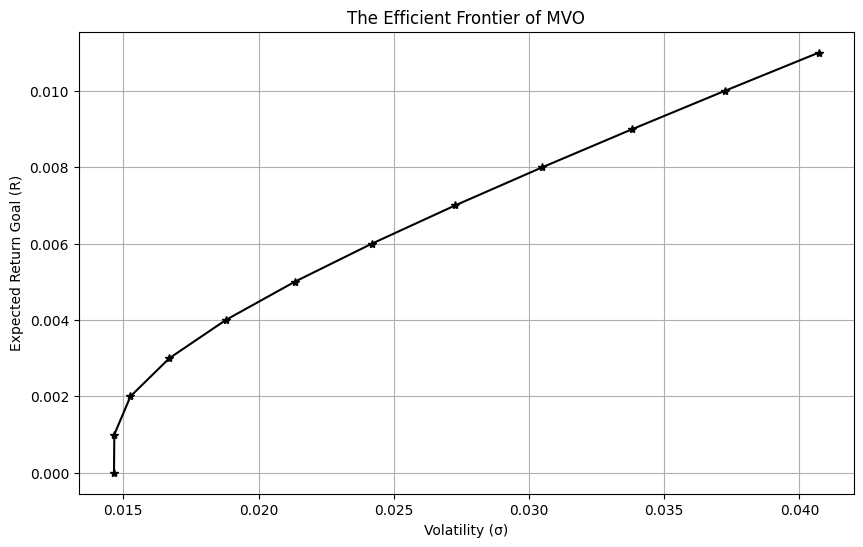

In [61]:
# Expected returns of assets
mu = np.array(geometric_expected_returns)

# Covariance matrix of the returns
Q = np.array(
    cov_matrix
)

# Define the return goals (from 0% to 3%)
goal_R = np.arange(0, 1.2, 0.1) / 100

# Convert Q to cvxopt matrix
P = matrix(Q)

# Linear term (f), typically zeros in mean-variance optimization
q = matrix(np.zeros(3))

# Arrays to store results for plotting the efficient frontier
std_deviations = []
portfolio_returns = []
portfolio_risks = []
weights_list = []

for R in goal_R:
    # Define inequality constraints: A * x >= b (converting >= to <=)
    G = matrix(-mu.reshape(1, -1))
    h = matrix(-R)

    # Define equality constraint: sum of weights = 1
    A_eq = matrix(np.ones((1, 3)))
    b_eq = matrix(1.0)

    # Solve the quadratic program
    sol = solvers.qp(P, q, G, h, A_eq, b_eq)

    # Extract the weights
    weights = np.array(sol['x']).flatten()

    # Calculate portfolio variance
    portfolio_variance = weights @ Q @ weights
    portfolio_std_dev = np.sqrt(portfolio_variance)

    # Store the results
    std_deviations.append(portfolio_std_dev)
    portfolio_returns.append(R)
    portfolio_risks.append(portfolio_std_dev)
    weights_list.append(weights)

results_df = pd.DataFrame(weights_list, columns=stocks)
results_df['Return Goal (R)'] = portfolio_returns
results_df['Portfolio Risk (σ)'] = portfolio_risks

# Display the table
print("\nResults Table:")
print(results_df)

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.plot(std_deviations, portfolio_returns, '-k*')
plt.xlabel('Volatility (σ)')
plt.ylabel('Expected Return Goal (R)')
plt.title('The Efficient Frontier of MVO')
plt.grid(True)
plt.show()


Results Table:
         SPY      GOVT      EEMV  Return Goal (R)  Portfolio Risk (σ)
0   0.049269  0.931581  0.019150            0.000            0.014658
1   0.041272  0.923030  0.035698            0.001            0.014670
2  -0.009257  0.868993  0.140264            0.002            0.015267
3  -0.060612  0.814072  0.246540            0.003            0.016706
4  -0.111951  0.759168  0.352782            0.004            0.018792
5  -0.163286  0.704269  0.459017            0.005            0.021336
6  -0.214623  0.649367  0.565256            0.006            0.024194
7  -0.265964  0.594462  0.671501            0.007            0.027268
8  -0.317305  0.539556  0.777749            0.008            0.030493
9  -0.368646  0.484650  0.883997            0.009            0.033825
10 -0.419988  0.429743  0.990244            0.010            0.037235
11 -0.471330  0.374837  1.096493            0.011            0.040704

Part 2
